# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS109A Introduction to Data Science 

## Lecture 15 (Decision Trees)

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br>


---

In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble


# Here are the decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

#import seaborn as sns
#pd.set_option('display.width', 1500)
#pd.set_option('display.max_columns', 100)
#sns.set(style="ticks")
#sns.set_context('poster')

In [2]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Blues'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax

In [3]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens'):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='green')
        ax.scatter(x[y==0,0], x[y==0,1], c='grey')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=0.1, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [5]:
npoints = 200 
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=npoints)
data = np.hstack((data, np.zeros((npoints, 1))))

data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(data[data[:, 0]**2 + data[:, 1]**2 < 3**2]), p=[0.2, 0.8])

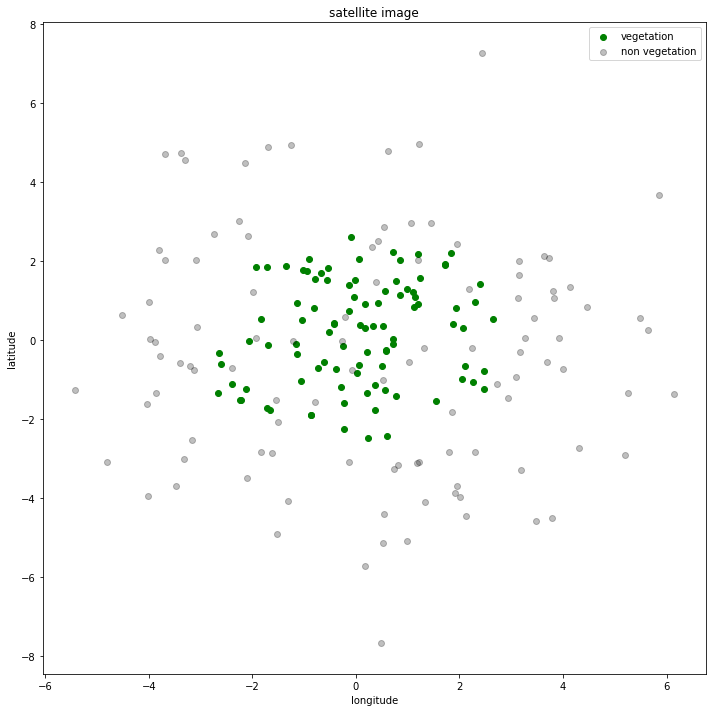

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = data[:, :-1]
y = data[:, -1]
ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='black', label='non vegetation', alpha=0.25)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('satellite image')
ax.legend()
plt.tight_layout()
plt.show() 

## Classification Trees

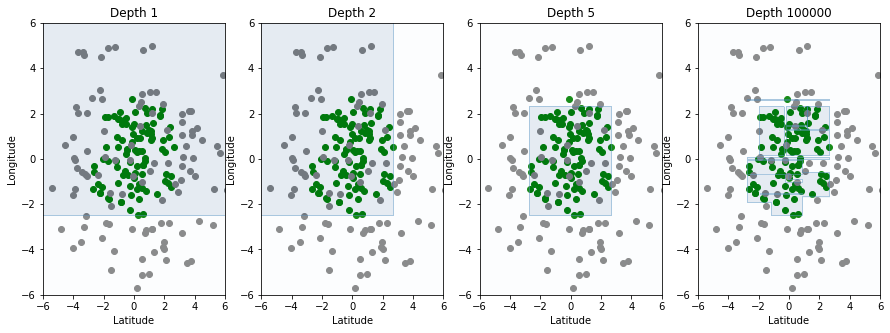

In [7]:
#Different Depths
depths = [1, 2, 5, 100000]
fig, ax = plt.subplots(1, len(depths), figsize=(15, 5))
x = data[:, :-1]
y = data[:, -1]
ind = 0
for i in depths:
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    ax[ind].set_xlim(-6, 6)
    ax[ind].set_ylim(-6, 6)
    ind += 1    

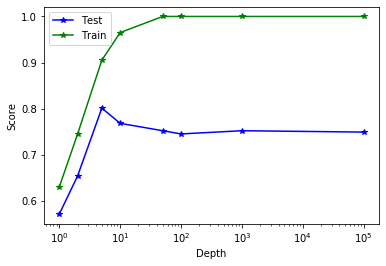

In [8]:
#Overfitting

depths = [1, 2, 5,10, 50, 100, 1000, 100000]

test_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
test_data = np.hstack((test_data, np.zeros((1000, 1))))
test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

scores = []
scores_train = []
for depth in depths:
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)
    scores.append(dt.score(x_test, y_test))
    scores_train.append(dt.score(x, y))
    
plt.plot(depths, scores, 'b*-', label = 'Test')
plt.plot(depths, scores_train, 'g*-', label = 'Train')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.xscale('log')
plt.legend()



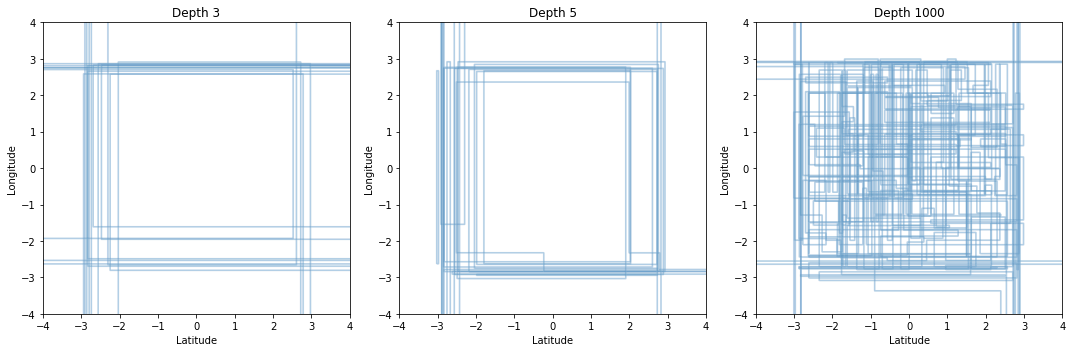

In [9]:
#Variance comparison between simple and complex models
depths = [3, 5, 1000]

fig, ax = plt.subplots(1, len(depths), figsize=(15, 5))

for d in range(len(depths)):
    for i in range(10):
        new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
        new_data = np.hstack((new_data, np.zeros((200, 1))))
        new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
        x = new_data[:, :-1]
        y = new_data[:, -1]
        ax[d] = fit_and_plot_dt(x, y, depths[d], 'Depth {}'.format(depths[d]), ax[d], plot_data=False, fill=False) 
        ax[d].set_xlim(-4, 4)
        ax[d].set_ylim(-4, 4)
plt.tight_layout()
plt.show() 

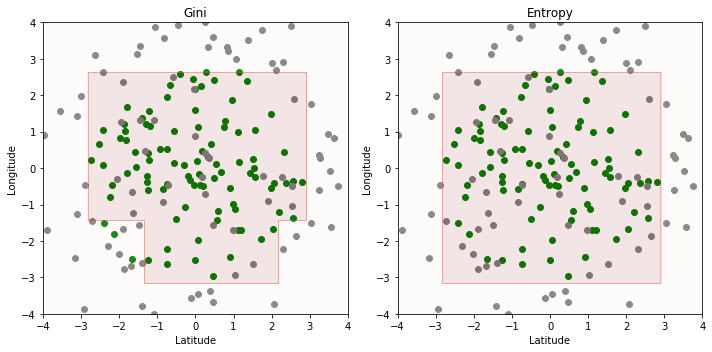

In [10]:
#Different Splitting Criteria
depth = 5

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
new_data = np.hstack((new_data, np.zeros((200, 1))))
new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x = new_data[:, :-1]
y = new_data[:, -1]

dt = tree.DecisionTreeClassifier(max_depth = depth)
dt.fit(x, y)

ax[0] = plot_tree_boundary(x, y, dt, 'Gini', ax[0], color='Reds')

dt = tree.DecisionTreeClassifier(max_depth = depth, criterion='entropy')
dt.fit(x, y)

ax[1] = plot_tree_boundary(x, y, dt, 'Entropy', ax[1], color='Reds')


ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-4, 4)
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)
        
plt.tight_layout()
plt.show() 

/home/dev15/anaconda3/envs/pandai/lib/python3.7/site-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


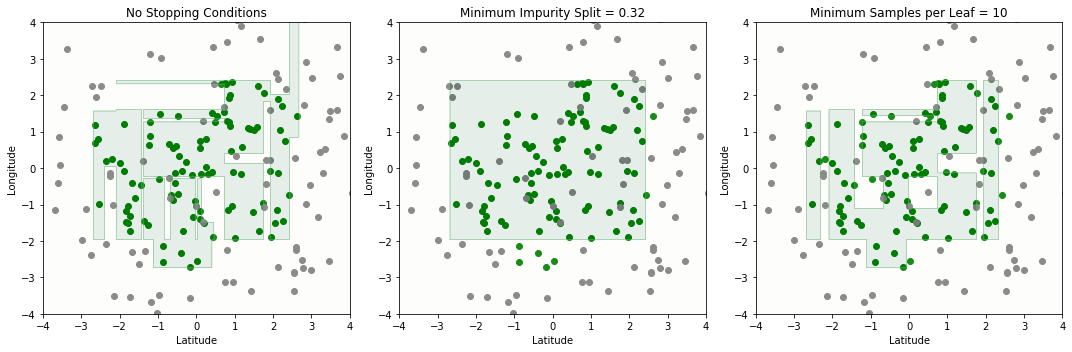

In [11]:
#Different Stopping Conditions

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
new_data = np.hstack((new_data, np.zeros((200, 1))))
new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x = new_data[:, :-1]
y = new_data[:, -1]

dt = tree.DecisionTreeClassifier()
dt.fit(x, y)

ax[0] = plot_tree_boundary(x, y, dt, 'No Stopping Conditions', ax[0])

dt = tree.DecisionTreeClassifier(min_impurity_split=0.32)
dt.fit(x, y)

ax[1] = plot_tree_boundary(x, y, dt, 'Minimum Impurity Split = 0.32', ax[1])

dt = tree.DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(x, y)

ax[2] = plot_tree_boundary(x, y, dt, 'Minimum Samples per Leaf = 10', ax[2])

ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-4, 4)
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)
ax[2].set_xlim(-4, 4)
ax[2].set_ylim(-4, 4)      

plt.tight_layout()
plt.show() 

## Hot dog data!

In [13]:
hotdog_df = pd.read_csv("data/hotdog.csv")

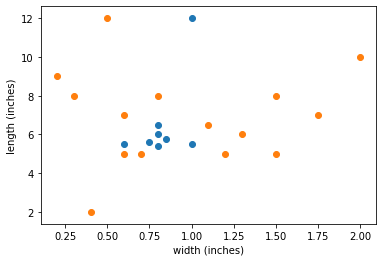

In [14]:

plt.scatter(hotdog_df['width'][hotdog_df['hotdog']==1],hotdog_df['length'][hotdog_df['hotdog']==1]);
plt.scatter(hotdog_df['width'][hotdog_df['hotdog']==0],hotdog_df['length'][hotdog_df['hotdog']==0]);

plt.xlabel("width (inches)")
plt.ylabel("length (inches)");

In [15]:
from sklearn import tree
clf_2 = tree.DecisionTreeClassifier(max_depth=2)
clf_3 = tree.DecisionTreeClassifier(max_depth=3)
clf_full = tree.DecisionTreeClassifier()

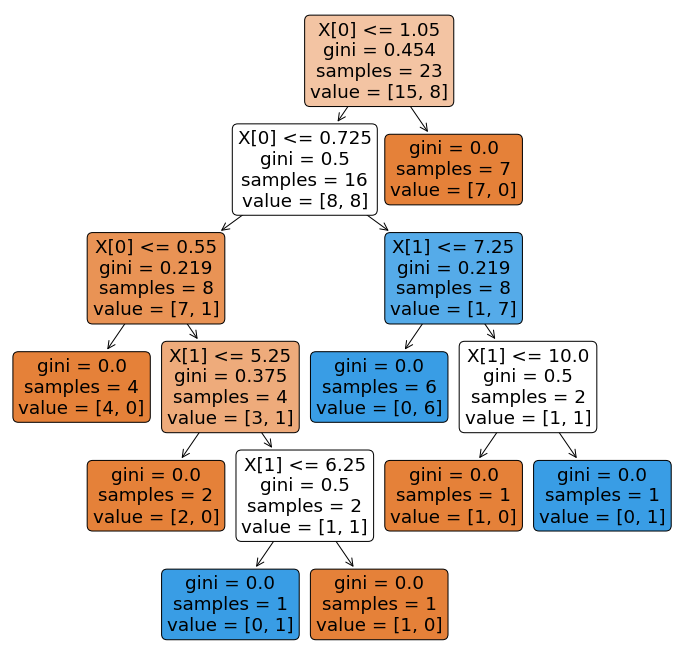

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
tree.plot_tree(clf_full.fit(hotdog_df[['width','length']], hotdog_df['hotdog']),filled=True,rounded=True);


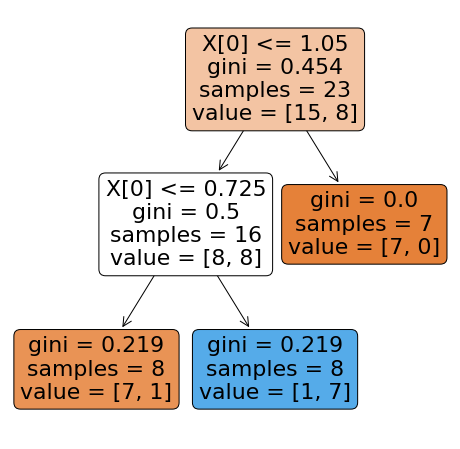

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
tree.plot_tree(clf_2.fit(hotdog_df[['width','length']], hotdog_df['hotdog']),filled=True,rounded=True);


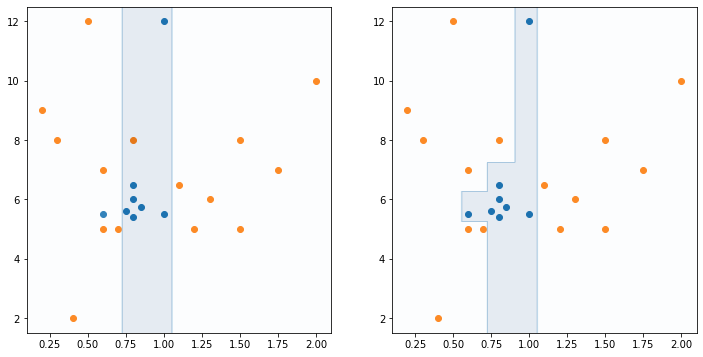

In [18]:
# Refit models:
clf_2.fit(hotdog_df[['width','length']], hotdog_df['hotdog'])
clf_full.fit(hotdog_df[['width','length']], hotdog_df['hotdog'])


# CREATE MESH
interval = np.arange(min(hotdog_df['width'].min()-1, hotdog_df['length'].min()-1),max(hotdog_df['width'].max()+1, hotdog_df['length'].max()+1),0.01)
n = np.size(interval)
#x1, x2 = np.meshgrid(np.arange(hotdog_df['width'].min(), hotdog_df['width'].max(),0.1),np.arange(hotdog_df['length'].min(), hotdog_df['length'].max(),0.1))
x1, x2 = np.meshgrid(interval,interval)
x1 = x1.reshape(-1,1)
x2 = x2.reshape(-1,1)
xx = np.concatenate((x1, x2), axis=1)

# PREDICT ON MESH POINTS
yy2 = clf_2.predict(xx)    
yy2 = yy2.reshape((n, n))

# PLOT DECISION SURFACE
x1 = x1.reshape(n, n)
x2 = x2.reshape(n, n)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(hotdog_df['width'][hotdog_df['hotdog']==1],hotdog_df['length'][hotdog_df['hotdog']==1])
ax[0].scatter(hotdog_df['width'][hotdog_df['hotdog']==0],hotdog_df['length'][hotdog_df['hotdog']==0])
#ax[0].xlabel("width (inches)")
#ax[0].ylabel("length (inches)")

ax[0].set_xlim([hotdog_df['width'].min()-0.1, hotdog_df['width'].max()+0.1])
ax[0].set_ylim([hotdog_df['length'].min()-0.5, hotdog_df['length'].max()+0.5])
ax[0].contourf(x1, x2, yy2, alpha=0.1, cmap='Blues')


# PREDICT ON MESH POINTS
yyfull = clf_full.predict(xx)    
yyfull = yyfull.reshape((n, n))

ax[1].scatter(hotdog_df['width'][hotdog_df['hotdog']==1],hotdog_df['length'][hotdog_df['hotdog']==1])
ax[1].scatter(hotdog_df['width'][hotdog_df['hotdog']==0],hotdog_df['length'][hotdog_df['hotdog']==0])

ax[1].set_xlim([hotdog_df['width'].min()-0.1, hotdog_df['width'].max()+0.1])
ax[1].set_ylim([hotdog_df['length'].min()-0.5, hotdog_df['length'].max()+0.5])
ax[1].contourf(x1, x2, yyfull, alpha=0.1, cmap='Blues');
    
plt.show()

## Regression Trees

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


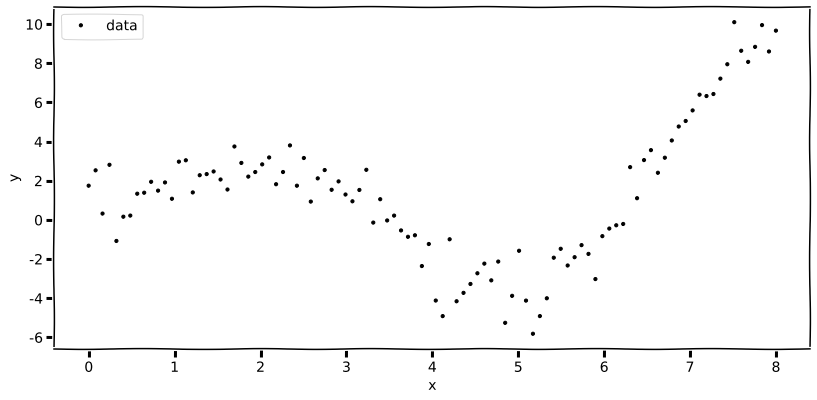

In [19]:
# Create fake data with x*sin(x) 

npt=100
np.random.seed(94)
x = np.linspace(0,8, npt)
x = x.reshape(-1,1)
y = x * np.sin(x) + np.random.normal(loc=0, scale=1, size=(npt,1)) +1

plt.xkcd(scale=0.4, length=0.0)
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


eta = .5 


plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y, '.', color='k', label='data')
plt.legend()


#plt.savefig('../fig/GB1.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()


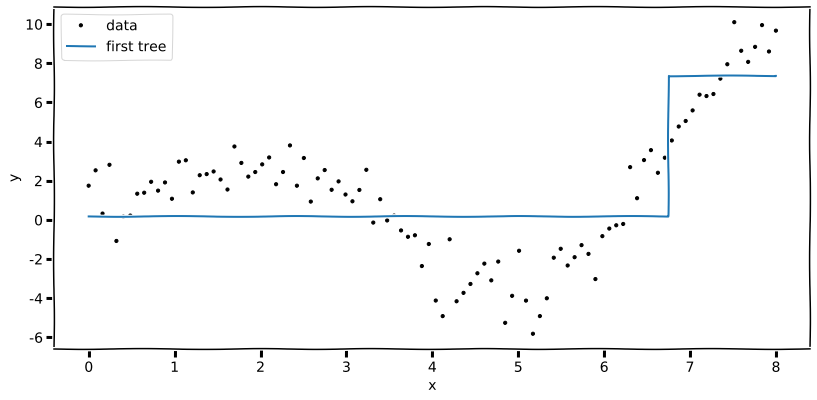

In [20]:
##### Decision Tree with 1 split
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


reg1 = DecisionTreeRegressor(max_depth=1)
reg1.fit(x,y)

xx = np.arange(0,8,.001)
y_pred = reg1.predict(xx.reshape(-1,1))


plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y, '.', color='k', label='data')
plt.plot(xx,y_pred, '-', label='first tree')
plt.legend()

#plt.savefig('../fig/GB2.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()


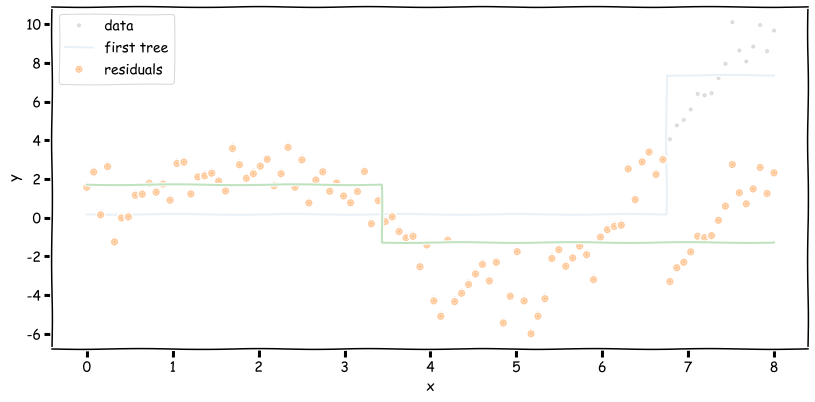

In [146]:
#########
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


# calculate the observed residuals 
y_hat = reg1.predict(x)
res = y - y_hat.reshape(-1,1)

# fit residual 
reg1.fit(x, res)

r_pred = reg1.predict(xx.reshape(-1,1))

plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, '.', color='k', label='data', alpha=0.1)
plt.plot(xx, y_pred, '-', label='first tree' ,alpha=0.1)

plt.plot(x, res, 'o', label='residuals' ,alpha=0.8)
plt.plot(xx, r_pred, label='residual tree' ,alpha=0.8)

plt.legend()
#plt.savefig('../fig/GB3.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()



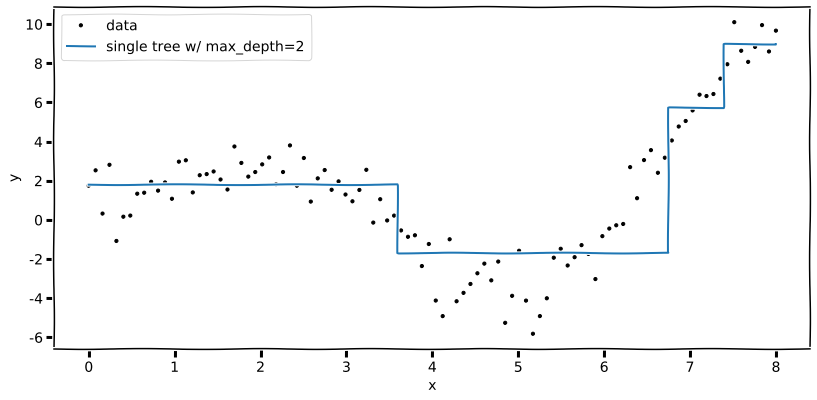

In [21]:
###### 
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


reg2 = DecisionTreeRegressor(max_depth=2)
reg2.fit(x,y)

xx = np.arange(0,8,.001)
y_pred = reg2.predict(xx.reshape(-1,1))


plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y, '.', color='k', label='data')
plt.plot(xx,y_pred, '-', label='single tree w/ max_depth=2')
plt.legend()

#plt.savefig('../fig/reg3.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()


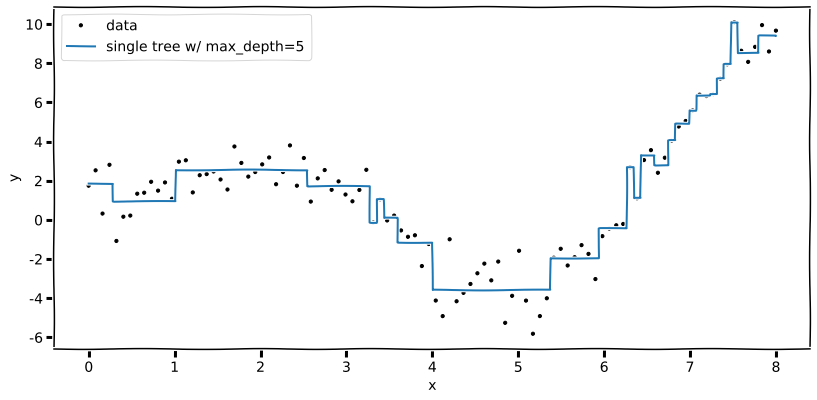

In [22]:
###### 
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


reg5 = DecisionTreeRegressor(max_depth=5)
reg5.fit(x,y)

xx = np.arange(0,8,.001)
y_pred = reg5.predict(xx.reshape(-1,1))


plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y, '.', color='k', label='data')
plt.plot(xx,y_pred, '-', label='single tree w/ max_depth=5')
plt.legend()

#plt.savefig('../fig/reg3.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()


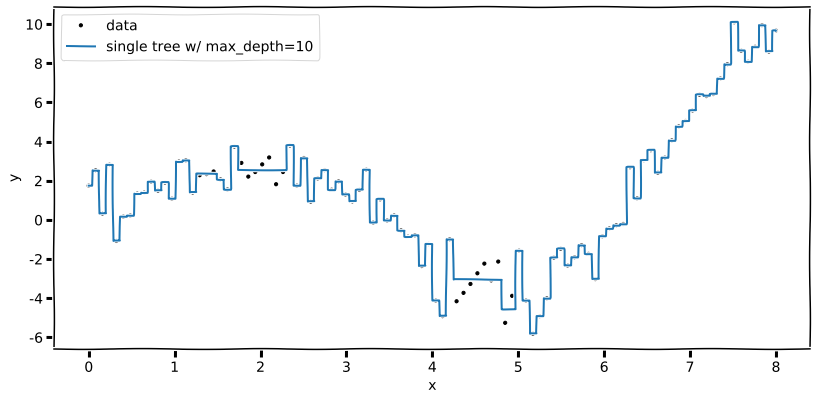

In [23]:
###### 
fig =plt.figure(figsize=(15, 7))
fig.patch.set_alpha(0.0)
plt.gcf().subplots_adjust(bottom=0.20, left = 0.2, right=None)


reg10 = DecisionTreeRegressor(max_depth=10)
reg10.fit(x,y)

xx = np.arange(0,8,.001)
y_pred = reg10.predict(xx.reshape(-1,1))


plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y, '.', color='k', label='data')
plt.plot(xx,y_pred, '-', label='single tree w/ max_depth=10')
plt.legend()

#plt.savefig('../fig/reg3.png', dpi=300,bbox_inches=0, transparent=True)
plt.show()
